# 单整，协整和平稳性
by Delaney Granizo-Mackenzie and Maxwell Margenot

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)



In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

# 平稳性/非平稳性

时间序列分析中一个通常未经检验的假设是数据的平稳性。当数据生成过程的参数不随时间变化时，数据是平稳的。作为一个例子，我们考虑两个系列，A和B。A系列是由一个固定参数的平稳过程生成的，B系列是由随着时间变化的参数生成的。

In [2]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

### 序列A

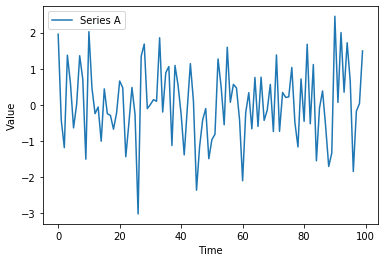

In [3]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)

plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

### 序列B

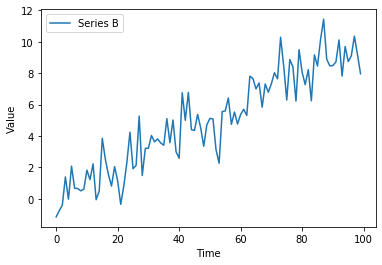

In [4]:
# Set the number of datapoints
T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)

plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B']);

### 为什么非平稳是危险的

许多统计测试，在他们假设的细节中，要求被测试的数据是平稳的。此外，如果您天真地在非平稳数据集上使用某些统计数据，您将得到垃圾结果。举个例子，我们通过非平稳的$B$取平均值。

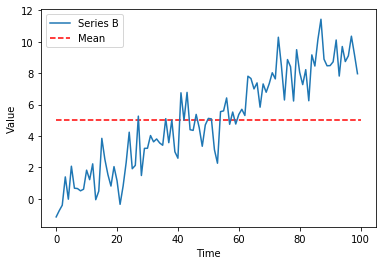

In [5]:
m = np.mean(B)

plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B', 'Mean']);

计算出的平均值将显示所有数据点的平均值，但对预测未来状态没有任何用处。与任何特定时间相比，它都是没有意义的，因为它是不同时间不同状态的集合。这只是一个简单而清晰的例子，说明为什么非平稳性会干扰分析，而在实践中会出现更多微妙的问题。

### 平稳性检验

现在我们要用统计检验来检验平稳性。

In [6]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print ('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print ('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

In [7]:
check_for_stationarity(A);
check_for_stationarity(B);

p-value = 2.666810565785102e-19 The series A is likely stationary.
p-value = 0.8115692620809147 The series B is likely non-stationary.


毫无疑问，序列的变化均值使得它是非平稳的。让我们尝试一个更微妙的例子。

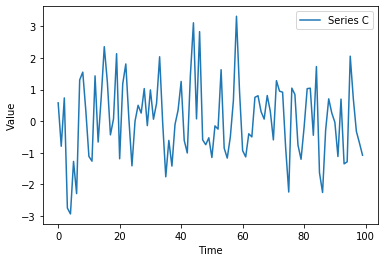

In [8]:
# Set the number of datapoints
T = 100

C = pd.Series(index=range(T))
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    C[t] = generate_datapoint(params)

plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C']);

均值的循环运动将很难与随机噪声区分开。在实际应用中，对于有噪声的数据和有限的样本量，很难确定一个序列是否是平稳的，漂移是随机噪声还是趋势的一部分。在每个单独的情况下，测试可能会也可能不会发现这样的细微影响。

In [9]:
check_for_stationarity(C);

p-value = 7.722406888920033e-11 The series C is likely stationary.


## 单整阶数

### 移动平均表示/Wold定理

时间序列分析中的一个重要概念是移动平均表示。我们将在这里简要讨论这个问题，但更完整的解释可以在[quantlecture Series](https://www.quantopian.com/lectures)的AR、MA和ARMA模型讲座中找到。也可以看看下面列出的维基百科。

该表达式表示任意时间序列$Y_t$为

$$Y_t = \sum_{j=0}^\infty b_j \epsilon_{t-j} + \eta_t$$

* $\epsilon$是新息序列
* $b_j$ 是信息序列的移动平均权重
* $\eta$是一个确定性序列

这里的关键如下。$\eta$是确定的，例如一个正弦波。因此我们可以完美地模拟它。新息过程是随机的，它模拟随着时间的推移出现的新信息。具体来说，$\epsilon on_t = \hat Y_t - Y_t$，其中$\hat Y_t$是$Y_t$的最优预测，只使用$t$之前的信息。换句话说，在时间$t-1$时所能做出的最佳预测无法解释$\epsilon$的随机性。

每个$b_j$只表示以前的$\epsilon$对$Y_t$的影响。


### 回到单整阶数

我们将把单整阶数i记作$I(i)$。

如果下列条件在移动平均表示中成立，则时间序列称为$I(0)$。这意味着，序列的自相关衰减得足够快。

$$\sum_{k=0}^\infty |b_k|^2 < \infty$$

这个性质对所有的平稳序列都成立，但仅凭它本身还不足以使平稳性成立。这意味着平稳性意味着$I(0)$，但是$I(0)$并不意味着平稳性。有关单整阶数的更多信息，请参见以下链接。

https://en.wikipedia.org/wiki/Order_of_integration
https://en.wikipedia.org/wiki/Wold%27s_theorem

### $I(0)$检验

在实践中，检验自相关的和是否有限可能是不可能的。这在数学推导中是可能的，但当我们有一个有限的数据集和有限数量的估计自相关时，总和总是有限的。考虑到这个困难，$I(0)$的测试依赖于表示属性的平稳性。如果我们发现一个序列是平稳的，那么它一定也是$I(0)$。

我们取原始的平稳序列A，因为A是平稳的，我们知道它也是$I(0)$。

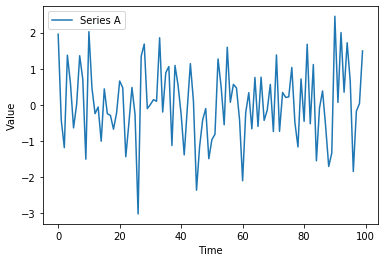

In [10]:
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

### 归纳地建立单整阶数

如果取$I(0)$序列，并将其累加和(离散积分)，则新序列为$I(1)$。注意这是如何与积分的微积分概念相联系的。同样的关系也适用于一般情况，要得到$I(n)$需要$I(0)$序列，然后迭代地将累积和$n$次。

现在我们用A的累加和来做一个$I(1)$序列。

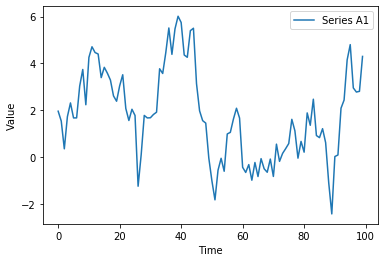

In [11]:
A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1']);

现在让我们通过计算累加和得到$I(2)$。

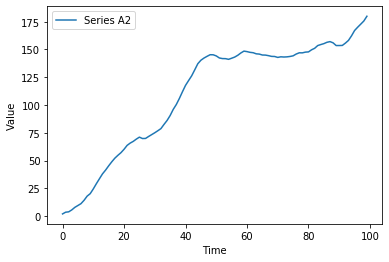

In [12]:
A2 = np.cumsum(A1)

plt.plot(A2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A2']);

### 分解单整阶数

相反地，为了找到给定级数的积分顺序，我们执行累加和的逆操作，即$\Delta$或逐项差分函数。具体地说

$$(1-L) X_t = X_t - X_{t-1} = \Delta X$$

$$(1-L)^d X_t$$

在本例中，$L$是滞后操作符。有时也写作$B$表示“回退”。$L$获取时间序列中第二个到最后一个元素，$L^k$获取第k个到最后一个元素。所以

$$L X_t = X_{t-1}$$


$$(1-L) X_t = X_t - X_{t-1}$$

如果$Y_t - Y_t-1$是$I(0)$，则序列$Y_t$是$I(1)$.换句话说，如果取$I(0)$序列，并将其累加和，就会得到$I(1)$序列。


### 重要提示

一旦所有的数学问题都解决了，记住任何的平稳级数都是$I(0)$

## 真实的数据

让我们在一些真实的价格数据上尝试一下。

In [13]:
import yfinance as yf
symbol_list = ['MSFT']
prices = yf.download(symbol_list, '2014-01-01','2015-01-01')['Close']
X = prices

[*********************100%***********************]  1 of 1 completed


In [15]:
prices = yf.download('MSFT', '2014-01-01','2015-01-01')['Close']

[*********************100%***********************]  1 of 1 completed


In [16]:
symbol = "CMG"
start = "2012-01-01"
end = "2016-01-01"
prices =yf.download(symbol, '2014-01-01','2015-01-01')['Close']
monthly_prices=prices.resample('M').median()

[*********************100%***********************]  1 of 1 completed


In [17]:
check_for_stationarity(X);

p-value = 0.6866401368562027 The series Close is likely non-stationary.


我们来看一下，当然有非平稳序列的警告信号。

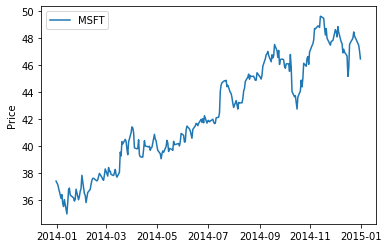

In [19]:
X.name='MSFT'
plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend([X.name]);

现在我们求序列的差分，得到加法回报率。我们来看看这是不是平稳的。

p-value = 1.3728436894765061e-28 The series MSFT Additive Returns is likely stationary.


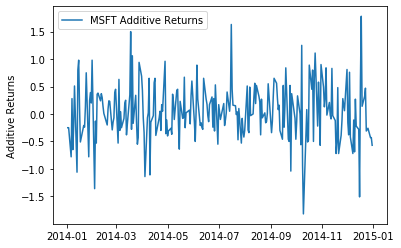

In [20]:
X1 = X.diff()[1:]
X1.name = X.name + ' Additive Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Additive Returns')
plt.legend([X1.name]);

似乎2014年的加法回报率是平稳的。这意味着我们可能能够建立比价格更好的回报模型。它也意味着价格是$I(1)$。

我们再来检查乘法回报率。

p-value = 7.467659710659871e-29 The series MSFT Multiplicative Returns is likely stationary.


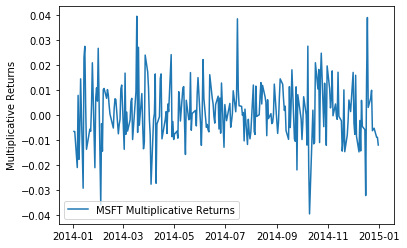

In [21]:
X1 = X.pct_change()[1:]
X1.name = X.name + ' Multiplicative Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Multiplicative Returns')
plt.legend([X1.name]);

看起来加法回报率也是平稳的。序列上的乘法和加法都得到相似的信息，所以它们都是平稳的就不足为奇了。在实践中，情况可能并非总是如此。

## 重要提示

和往常一样，你不应该天真地认为，因为时间序列在过去是平稳的，所以它在未来也将是平稳的。对平稳性的一致性进行交叉验证和样本外检验是必要的。这适用于任何统计性质，我们只是在这里重申一下。回报也可能是时平稳时不平稳的，也可能是平稳的，也可能是非平稳的，这取决于时间范围和采样频率。


## 注意:回报分析

回报通常用于量化金融建模的原因是，它们比价格更稳定。这使得它们更容易建模，回报预测也更可行。预测价格是比较困难的，因为有许多趋势是由$I(1)$单整引起的。即使是使用收益预测模型来预测价格也是很棘手的，因为随着时间的推移，收益预测中的任何错误都会被放大。

## 协整

最后，既然我们已经讨论了平稳性和单整阶数，我们就可以讨论协整了。

### 定义线性组合

时间序列($X_1$， $X_2$， $\dots$， $X_k$)的线性组合是一个新的时间序列$Y$，对任意一组实数$b_1 \dots b_k$构造如下

$$Y = b_1X_1 + b_2X_2 + \dots + b_kX_k$$

### 正式定义

协整的正式定义如下。

对于某个时间序列集合($X_1$， $X_2$， $\dots$， $X_k$)，如果所有的序列都是$I(1)$，并且它们的某个线性组合是$I(0)$，我们说这个时间序列集合是协整的。

#### 例子

$X_1$, $X_2$,和$X_3$都是$I(1)$,$2X_1 + X_2 + 0X_3 = 2X_1 + X_2$是$I(0)$。在这种情况下，时间序列是协整的。

### 直觉

这里的直觉是，对于级数的某些线性组合，结果缺乏太多的自协方差，而且大多是噪声。这对于配对交易很有用，我们发现两种资产的价格是协整的。由于他们的价格$b_1A_1 + b_2A_2$的线性组合是噪声，我们可以打赌$b_1A_1 + b_2A_2$的关系会恢复并相应地进行交易。有关更多信息，请参见[quantlecture系列](https://www.quantopian.com/lectures)中的配对交易讲座。

### 模拟数据的例子

让我们用一些数据来证明这一点。

In [22]:
# Length of series
N = 100

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# Make an X2 that is X1 plus some noise
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

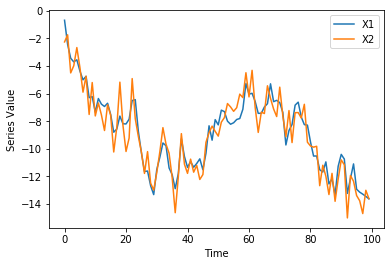

In [23]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

因为$X_2$是一个$I(1)$序列加上一些固定的噪声，所以它仍然是$I(1)$。让我们检查这个。

In [24]:
Z = X2.diff()[1:]
Z.name = 'Z'

check_for_stationarity(Z);

p-value = 2.222467684652079e-19 The series Z is likely stationary.


看起来不错。现在为了证明协整我们需要找到某个平稳的X_1和X_2的线性组合。我们可以取$X_2-X_1$。所有剩下的都是平稳的噪声。让我们检查这个。

p-value = 2.970627476815432e-17 The series Z is likely stationary.


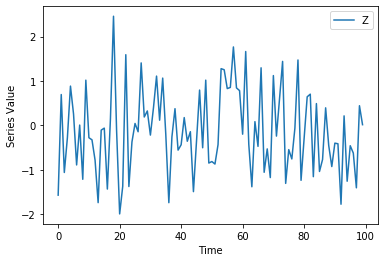

In [25]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['Z']);

check_for_stationarity(Z);

### 协整检验

有很多方法可以检验协整。这篇[维基百科文章](https://en.wikipedia.org/wiki/Cointegration)描述了一些。一般来说，我们只是试着解出系数$b_1， \dots b_k$它会产生一个$I(0)$线性组合。如果我们对这些系数的最佳猜测没有通过平稳性检验，那么我们就拒绝这个集合是协整的假设。这将导致第二类错误(假阴性)的风险，因为我们不会对所有的系数组合进行详尽的平稳性测试。然而，在这里，第二类错误通常是可以接受的，因为它们是安全的，不会导致我们做出任何错误的预测。

在实践中，对于时间序列对，一种常见的方法是使用线性回归来估计下面模型中的$\beta$。

$$X_2 = \alpha + \beta X_1 + \epsilon$$

这个想法是，如果这两个是协整的，我们可以去掉$X_2$对$X_1$的依赖，留下平稳的噪声。组合$X_2 - \beta X_1 = \alpha + \epsilon$应该是平稳的。

#### 真实数据的例子

让我们尝试一些真实的数据。我们先把价格画出来。

In [83]:
symbol_list =  ['ABGB', 'FSLR']
prices = yf.download(symbol_list, '2014-01-01', '2015-01-01')['Close']
prices.columns =['ABGB', 'FSLR']
X1 = prices[symbol_list[0]]
X2 = prices[symbol_list[1]]

[*********************100%***********************]  2 of 2 completed


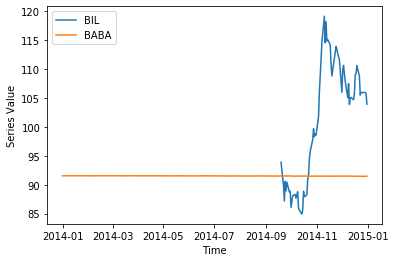

In [84]:
plt.plot(X1.index, X1.values)
plt.plot(X1.index, X2.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

现在使用线性回归来计算$\beta$。

In [80]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()

# Get rid of the constant column
X1 = X1[symbol_list[0]]

results.params

MissingDataError: exog contains inf or nans

p-value = 0.6767029352085323 The series Z is likely non-stationary.


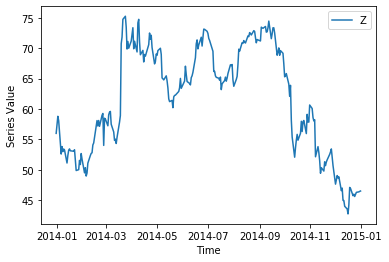

In [77]:
b = results.params[symbol_list[0]]
Z = X2 - b * X1
Z.name = 'Z'

plt.plot(Z.index, Z.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([Z.name]);

check_for_stationarity(Z);

我们可以看到，$Z$在我们观察的时间段内很可能是平稳的。这使我们接受了这样的假设:我们的两项资产在同一时间段内是协整的。

# 这只是一个预测!

请记住，与其他任何东西一样，您不应该假设因为某些资产集已经通过了历史上的协整测试，所以它们将继续保持协整。您需要验证是否发生了一致的行为，并像对待任何模型一样使用各种模型验证技术。

金融领域最重要的事情之一就是进行许多独立的押注。在这里，定量分析师会发现，他们假设的许多对资产都是协整的，并在押注中平均分配他们的美元。这只需要超过一半的资产对保持协同集成，策略才能发挥作用。有关配对交易的更多信息，请参见quantlecture”系列中的“配对交易lecutres”。

[www.quantopian.com/lectures](https://www.quantopian.com/lectures)


### 现有的测试

幸运的是，有一些针对协整的预先构建的测试。这是一个。利用自己的时间阅读[文档](http://statsmodels.sourceforge.net/devel/_modules/statsmodels/tsa/stattools.html)。

In [71]:
from statsmodels.tsa.stattools import coint

coint(X1, X2)

(-1.8783209953703637,
 0.5909603673989795,
 array([-3.94042787, -3.36048387, -3.06132299]))